In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling as pp
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv("credit_risk_dataset.csv")
print(df.shape)
df.head(3)

(32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3


Checking null values

In [3]:
df.isnull().sum().sort_values(ascending=False)


loan_int_rate                 3116
person_emp_length              895
person_age                       0
person_income                    0
person_home_ownership            0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Removing duplicates and filling null values in loan_int_rate with median

In [4]:
df.drop_duplicates(inplace=True)

median_int= df["loan_int_rate"].median()
df["loan_int_rate"].fillna(median_int, inplace=True)

Filling null values in person_emp_length. Took the median of that column, divided to 2 parts at median. Filled null values above median values with  their median and values below median with their median.

In [5]:
abv_median = df[df["person_emp_length"] <=4]  #median is 4
below_median = df[df["person_emp_length"] >4]

abv_median["person_emp_length"].fillna(abv_median["person_emp_length"].median(), inplace=True)
below_median["person_emp_length"].fillna(below_median["person_emp_length"].median(), inplace=True)

data = pd.concat([abv_median,below_median])

C:\Users\koush\AppData\Local\Temp\ipykernel_6804\2901972086.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abv_median["person_emp_length"].fillna(abv_median["person_emp_length"].median(), inplace=True)
C:\Users\koush\AppData\Local\Temp\ipykernel_6804\2901972086.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  below_median["person_emp_length"].fillna(below_median["person_emp_length"].median(), inplace=True)


Function for capping outliers and boxplots

In [6]:

def handle_outliers(data):

    num_cols = data.select_dtypes(include=['float', 'int']).columns.tolist()
    print(num_cols, "\n")
    
    fig, axes = plt.subplots(nrows=1, ncols=len(num_cols), figsize=(20, 5))
    
 
    for i, col in enumerate(num_cols):
        
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Cap the outliers
        data.loc[data[col] < lower_bound, col] = lower_bound
        data.loc[data[col] > upper_bound, col] = upper_bound
        
        # Create boxplot for the feature
        sns.boxplot(x=col, data=data, ax=axes[i])
    
    plt.show()

['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'] 



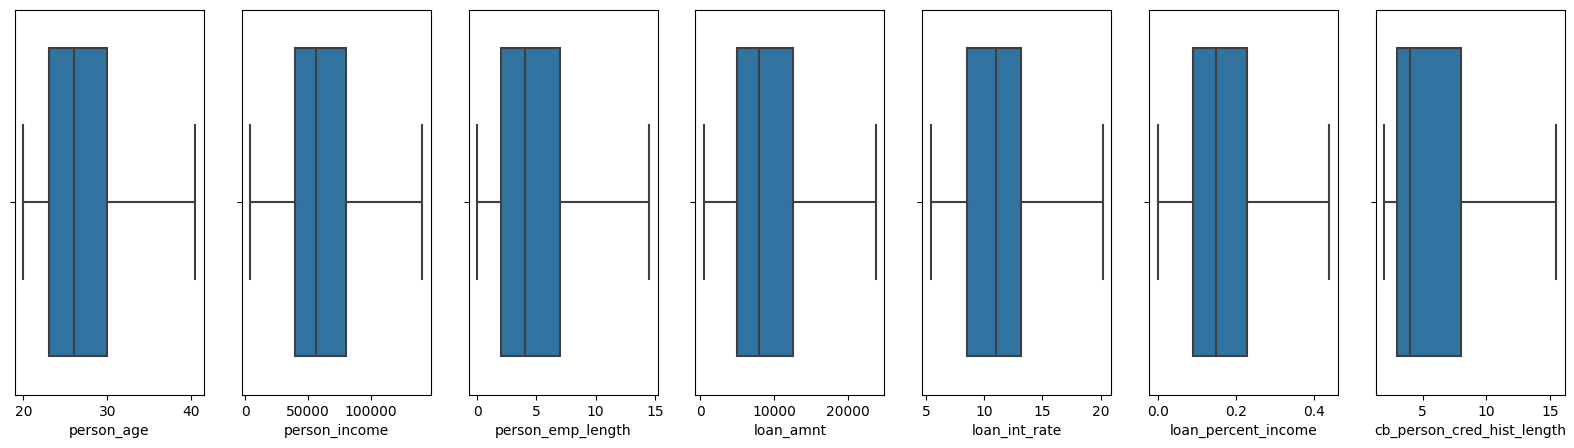

In [7]:
handle_outliers(data.drop(columns="loan_status"))

VIF score to check multicolliearnity in the features

In [8]:
def vif(data):
# Filter to include only numeric columns
    num_cols = data.select_dtypes(include=['float', 'int']).columns.tolist()

    # Calculate VIF for each feature
    vif = pd.DataFrame()
    vif['Feature'] = num_cols
    vif['VIF'] = [variance_inflation_factor(data[num_cols].values, i) for i in range(len(num_cols))]

    # Print the VIF dataframe
    print(vif)

In [9]:
vif(data)

                      Feature        VIF
0                  person_age  29.521678
1               person_income   3.196593
2           person_emp_length   2.462622
3                   loan_amnt   7.162678
4               loan_int_rate  12.257294
5                 loan_status   1.660250
6         loan_percent_income   7.998712
7  cb_person_cred_hist_length   7.495635


person_age has VIF 29.52, We can remove that, but I'm not removing it.

dividing features and target column

In [10]:
x= data.drop("loan_status",axis=1)
y = data["loan_status"]

Encoding catergorical columns

In [11]:
cat_cols = x.select_dtypes(include='object').columns.tolist()

data_encoded = pd.get_dummies(x, columns=cat_cols)

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_encoded), columns=data_encoded.columns)

In [12]:
x_train,x_test, y_train, y_test = train_test_split(data_scaled,y, test_size=0.25, random_state=42)

Since it is unbalanced dataset, Using SMOTE to make it balanced

In [13]:
# Instantiate the SMOTE object with desired options
smote = SMOTE(sampling_strategy='minority', k_neighbors=5)

# Apply SMOTE to the training data
X_resampled, y_resampled = smote.fit_resample(x_train, y_train)


Finding best paramters for logistic regression using grid search cv

In [14]:
param_grid = {
    'penalty' : ["l1", "l2"],
    'C': [0.1,1,10],
    'solver' : ["lbfgs","saga","liblinear"]    
}

In [15]:
lr = LogisticRegression(random_state=42)
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

C:\Users\koush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\koush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\koush\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-pack

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'saga', 'liblinear']})

In [16]:
print("Best Parameters :", grid_search.best_params_)
print("Best Score :", grid_search.best_score_)

Best Parameters : {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score : 0.8070930140622021


In [17]:
lr_best = LogisticRegression(C=10,penalty="l2", solver="lbfgs", random_state=42)

In [18]:
lr_best.fit(X_resampled,y_resampled)

LogisticRegression(C=10, random_state=42)

In [19]:
y_pred = lr_best.predict(x_test)

Classifying "1" is not that accurate.

In [20]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      6238
           1       0.53      0.76      0.62      1645

    accuracy                           0.81      7883
   macro avg       0.73      0.79      0.75      7883
weighted avg       0.85      0.81      0.82      7883



Now using Decision Tree to classify

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
dt = DecisionTreeClassifier()
dt.fit(X_resampled,y_resampled)

DecisionTreeClassifier()

In [23]:
y_preddt= dt.predict(x_test)

Better than logistic regression but lets try grid search cv

In [24]:
print(classification_report(y_test,y_preddt))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      6238
           1       0.66      0.76      0.71      1645

    accuracy                           0.87      7883
   macro avg       0.80      0.83      0.81      7883
weighted avg       0.88      0.87      0.87      7883



In [25]:
grid_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(2,32,1),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split': range(2,10,1),
    'splitter' : ['best', 'random']
    
}

In [26]:
grid_search = GridSearchCV(estimator=dt,
                     param_grid=grid_param,
                     cv=5,
                    n_jobs =-1)

In [ ]:
#grid_search.fit(X_resampled,y_resampled)

In [ ]:
# best_parameters = grid_search.best_params_
# print(best_parameters)

In [29]:
dt_best = DecisionTreeClassifier(criterion = 'entropy', max_depth =30, min_samples_leaf= 1, min_samples_split= 3, splitter ='best')
dt_best.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_split=3)

In [30]:
ypred_best = dt_best.predict(x_test)

After using grid search in decision tree paramters, it is now performing well.

In [31]:
print(classification_report(ypred_best, y_test))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      6220
           1       0.77      0.76      0.77      1663

    accuracy                           0.90      7883
   macro avg       0.85      0.85      0.85      7883
weighted avg       0.90      0.90      0.90      7883



In [41]:
dt_best.score(x_test,y_test)

0.9015603196752505